## 1) Daten aus CSV-Datei auslesen

In [1]:
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
import os
import csv
import tensorflow as tf

########## Input ##########

fits_path = 'F:\\data\\spectral_fits_gold_big\\'
samples_per_class = 2500

########## Program ##########

# Listen mit den flux Werten, Labels und Wellenlängen erstellen
data = np.load(fits_path + "data.npy")
labels = np.load(fits_path + "labels.npy")
wavelengths = np.load(fits_path + "wavelengths.npy")

# Liste die Galaxie-Nummer speichert
numbers = range(4*samples_per_class)

## 2) Daten Plotten

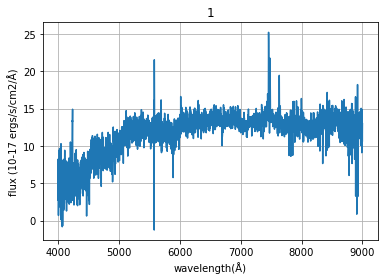

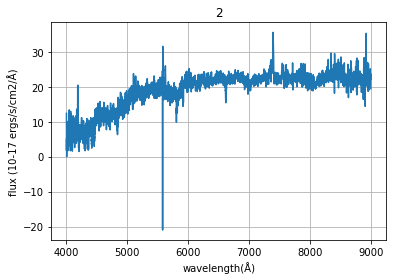

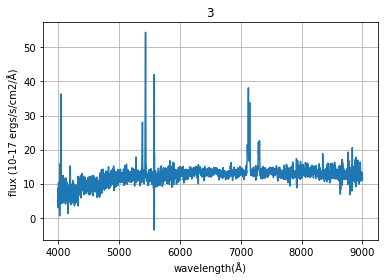

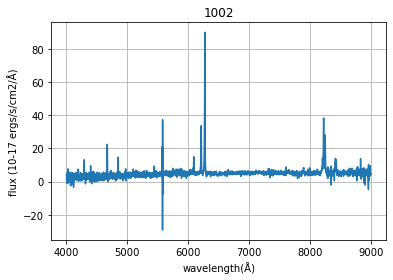

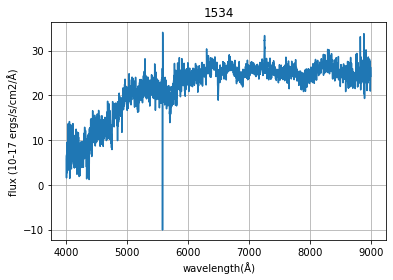

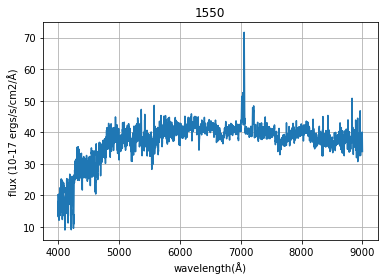

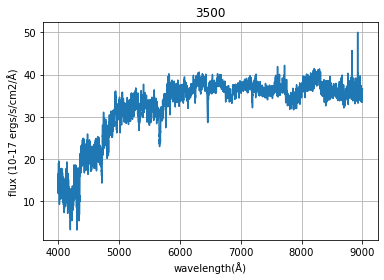

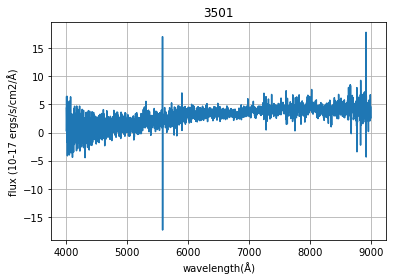

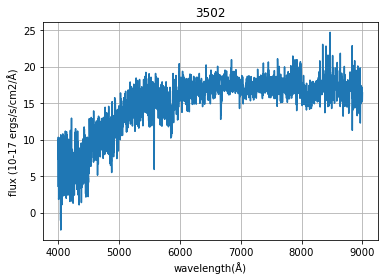

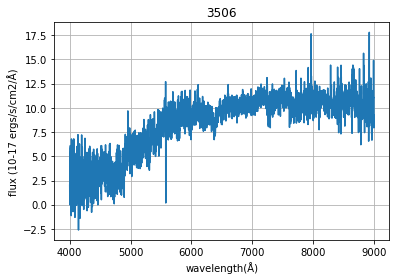

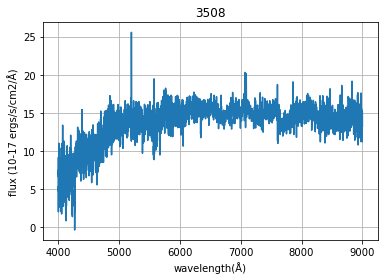

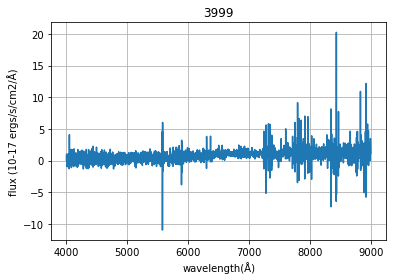

In [3]:
for i in [1, 2, 3, 1002, 1534, 1550, 3500,3501,3502,3506,3508,3999]: #1534  
    plt.plot(wavelengths, data[i]) 
    plt.xlabel('wavelength(Å)') 
    plt.ylabel('flux (10-17 ergs/s/cm2/Å)') 
    plt.grid(True)
    plt.title(str(i))
    plt.show()

## 3) Trainings- und Test-Datensatz erstellen

In [2]:
import random
# z = list(zip(data_normalized, labels)) # Mit Median-Normierung
z = list(zip(data, labels, numbers)) # Ohne Median-Normierung
random.shuffle(z)
data_shuffled, labels_shuffled, numbers_shuffled = zip(*z)

In [3]:
print(np.array(data_shuffled).shape)
print(np.array(labels_shuffled).shape)

(10000, 3522)
(10000,)


In [4]:
split_index = int(len(data_shuffled)*0.9)

# Daten
data_training = np.asarray(data_shuffled[:split_index])
data_test = np.asarray(data_shuffled[split_index:])

# Labels
labels_training = np.asarray(labels_shuffled[:split_index])
labels_test = np.asarray(labels_shuffled[split_index:])

# Galaxie numbers
numbers_training = numbers_shuffled[:split_index]
numbers_test = numbers_shuffled[split_index:]

## 4) Netzwerk erstellen

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv1D, MaxPooling1D, Dropout, InputLayer, GlobalAveragePooling1D
from tensorflow.keras.metrics import Accuracy

from tensorflow import keras
from tensorflow.keras import layers

In [6]:
input_shape = (3522,1)

data_training_r = np.reshape(data_training, newshape=(len(data_training), input_shape[0], input_shape[1]))
data_test_r  = np.reshape(data_test, newshape=(len(data_test), input_shape[0], input_shape[1]))

In [7]:
print(data_training_r.shape)
print(data_test_r.shape)

(9000, 3522, 1)
(1000, 3522, 1)


In [8]:
# Conv1D, maxPool1D, categorical_crossentropy
# model = Sequential([
#     #Conv1D(filters=30, kernel_size=10, activation='relu', input_shape=(3522,1)),
#     Conv1D(filters=64, kernel_size=5, activation='relu'), #mehr Filtern
#     MaxPooling1D(4), # Größere Region
#     Dropout(0.1),
#     #Conv1D(filters=60, kernel_size=10, activation='relu'),
#     Conv1D(filters=64, kernel_size=5, activation='relu'),
#     MaxPooling1D(4),
#     # GlobalAveragePooling1D(),
#     Dropout(0.1),
#     Flatten(),
    
#     Dense(units=64, activation='relu'),
#     #Extra Dense
    
#     Dense(units=4, activation='softmax')
# ])

# Am besten (schnell):
# model = Sequential([
#     Conv1D(filters=64, kernel_size=80, strides=10, activation='relu', input_shape=(3522,1)), # stride
#     MaxPooling1D(3), #Pooling verringert Accuracy leicht aber verhindert overfitting
#     Dropout(0.35),
#     Conv1D(filters=128, kernel_size=40, strides=10, activation='relu'),
#     MaxPooling1D(3),
#     Dropout(0.35),
#     Flatten(),
#     Dense(units=128, activation='relu'), # Droput, weniger neuronen
#     Dropout(0.35),
#     Dense(units=4, activation='softmax')
# ])

model = Sequential([
    Conv1D(filters=32, kernel_size=20, strides=10, activation='relu', input_shape=(3522,1)), # stride
    MaxPooling1D(3), #Pooling verringert Accuracy leicht aber verhindert overfitting
    Dropout(0.35),
    Conv1D(filters=64, kernel_size=40, strides=10, activation='relu'),
    MaxPooling1D(3),
    Dropout(0.35),
    Flatten(),
    Dense(units=128, activation='relu'), # Droput, weniger neuronen
    Dropout(0.35),
    Dense(units=4, activation='softmax')
])



# model = Sequential([
#     Conv1D(filters=64, kernel_size=40, strides=10, activation='relu', input_shape=(3522,1)), # stride
#     Dropout(0.2),
#     Conv1D(filters=128, kernel_size=20, strides=5, activation='relu'), # stride
#     Dropout(0.2),
#     Flatten(),
#     Dense(units=4, activation='softmax')
# ])

# Langsamer, aber auch gut (aus paper):
# model = Sequential([
#     Conv1D(filters=16, kernel_size=21, activation='relu', input_shape=(3522,1)),
#     MaxPooling1D(2),
#     Conv1D(filters=32, kernel_size=11, activation='relu'),
#     MaxPooling1D(2),
#     Conv1D(filters=64, kernel_size=5, activation='relu'),
#     MaxPooling1D(2),    
#     Flatten(),
#     Dense(units=64, activation='relu'),
#     Dropout(0.5),
#     Dense(units=4, activation='softmax')
# ])

In [9]:
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
# x_train = data_training_r
# x_test = data_test_r

x_train = tf.keras.utils.normalize(data_training_r, axis=1)
x_test = tf.keras.utils.normalize(data_test_r, axis=1)

y_train = labels_training
y_test = labels_test

In [11]:
history = model.fit(x_train, y_train,
                    epochs=200, validation_split=0.1,
                    shuffle=True, batch_size=200,
                    verbose=1)

# model_handler=Model.Model(shape=(height_dim,height_dim,lc_dim,1))


#model3 = tf.keras.models.load_model('spectral_classifier_v2.h5')
# model.save('spectral_classifier_v2.h5')

Epoch 1/200
41/41 [==============================] - 1s 31ms/step - loss: 1.3389 - accuracy: 0.4022 - val_loss: 1.1343 - val_accuracy: 0.4989
Epoch 2/200
41/41 [==============================] - 1s 33ms/step - loss: 1.0029 - accuracy: 0.5189 - val_loss: 0.9009 - val_accuracy: 0.6167
Epoch 3/200
41/41 [==============================] - 1s 35ms/step - loss: 0.8964 - accuracy: 0.5809 - val_loss: 0.8400 - val_accuracy: 0.6267
Epoch 4/200
41/41 [==============================] - 1s 29ms/step - loss: 0.8377 - accuracy: 0.6025 - val_loss: 0.7793 - val_accuracy: 0.6367
Epoch 5/200
41/41 [==============================] - 1s 29ms/step - loss: 0.7974 - accuracy: 0.6320 - val_loss: 0.7321 - val_accuracy: 0.6600
Epoch 6/200
41/41 [==============================] - 1s 29ms/step - loss: 0.7480 - accuracy: 0.6468 - val_loss: 0.6617 - val_accuracy: 0.6744
Epoch 7/200
41/41 [==============================] - 1s 28ms/step - loss: 0.7097 - accuracy: 0.6632 - val_loss: 0.6149 - val_accuracy: 0.7122
Epoch 

41/41 [==============================] - 1s 28ms/step - loss: 0.2995 - accuracy: 0.8720 - val_loss: 0.2708 - val_accuracy: 0.8911
Epoch 59/200
41/41 [==============================] - 1s 28ms/step - loss: 0.2951 - accuracy: 0.8748 - val_loss: 0.2619 - val_accuracy: 0.8911
Epoch 60/200
41/41 [==============================] - 1s 27ms/step - loss: 0.2978 - accuracy: 0.8731 - val_loss: 0.2611 - val_accuracy: 0.8856
Epoch 61/200
41/41 [==============================] - 1s 27ms/step - loss: 0.2954 - accuracy: 0.8721 - val_loss: 0.2608 - val_accuracy: 0.8944
Epoch 62/200
41/41 [==============================] - 1s 27ms/step - loss: 0.2941 - accuracy: 0.8727 - val_loss: 0.2605 - val_accuracy: 0.8867
Epoch 63/200
41/41 [==============================] - 1s 28ms/step - loss: 0.2922 - accuracy: 0.8764 - val_loss: 0.2592 - val_accuracy: 0.8911
Epoch 64/200
41/41 [==============================] - 1s 28ms/step - loss: 0.2976 - accuracy: 0.8717 - val_loss: 0.2599 - val_accuracy: 0.8911
Epoch 65/200

41/41 [==============================] - 1s 37ms/step - loss: 0.2460 - accuracy: 0.9000 - val_loss: 0.2166 - val_accuracy: 0.9111
Epoch 116/200
41/41 [==============================] - 1s 36ms/step - loss: 0.2482 - accuracy: 0.8938 - val_loss: 0.2164 - val_accuracy: 0.9133
Epoch 117/200
41/41 [==============================] - 1s 32ms/step - loss: 0.2382 - accuracy: 0.8969 - val_loss: 0.2191 - val_accuracy: 0.9133
Epoch 118/200
41/41 [==============================] - 1s 34ms/step - loss: 0.2366 - accuracy: 0.8989 - val_loss: 0.2292 - val_accuracy: 0.9044
Epoch 119/200
41/41 [==============================] - 1s 30ms/step - loss: 0.2383 - accuracy: 0.8974 - val_loss: 0.2176 - val_accuracy: 0.9100
Epoch 120/200
41/41 [==============================] - 1s 30ms/step - loss: 0.2356 - accuracy: 0.8998 - val_loss: 0.2223 - val_accuracy: 0.9067
Epoch 121/200
41/41 [==============================] - 1s 30ms/step - loss: 0.2400 - accuracy: 0.9036 - val_loss: 0.2158 - val_accuracy: 0.9067
Epoch 

Epoch 172/200
41/41 [==============================] - 1s 28ms/step - loss: 0.2132 - accuracy: 0.9107 - val_loss: 0.2119 - val_accuracy: 0.9056
Epoch 173/200
41/41 [==============================] - 1s 28ms/step - loss: 0.2048 - accuracy: 0.9165 - val_loss: 0.1968 - val_accuracy: 0.9189
Epoch 174/200
41/41 [==============================] - 1s 28ms/step - loss: 0.2140 - accuracy: 0.9130 - val_loss: 0.1941 - val_accuracy: 0.9189
Epoch 175/200
41/41 [==============================] - 1s 29ms/step - loss: 0.2086 - accuracy: 0.9143 - val_loss: 0.1968 - val_accuracy: 0.9222
Epoch 176/200
41/41 [==============================] - 2s 39ms/step - loss: 0.2027 - accuracy: 0.9163 - val_loss: 0.1975 - val_accuracy: 0.9156
Epoch 177/200
41/41 [==============================] - 1s 32ms/step - loss: 0.2083 - accuracy: 0.9122 - val_loss: 0.1954 - val_accuracy: 0.9222
Epoch 178/200
41/41 [==============================] - 1s 35ms/step - loss: 0.2089 - accuracy: 0.9158 - val_loss: 0.1920 - val_accuracy:

## 5) Auswertungen

In [12]:
def plot_accuracy(name, ylim=[0,1.01]):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.ylim(ylim[0], ylim[1])
    plt.legend(['training', 'validation'], loc='upper left')
    plt.savefig(name)
    plt.show()

In [15]:
def plot_loss(name, ylim=[0,2]):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.ylim(ylim[0],ylim[1])
    plt.legend(['training', 'validation'], loc='upper left')
    plt.savefig(name)
    plt.show()


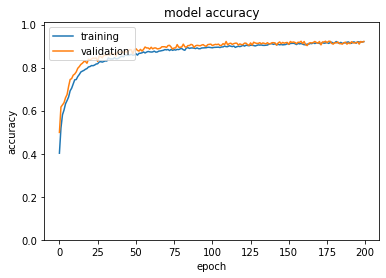

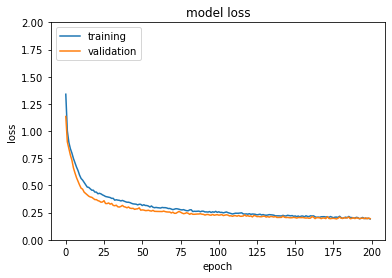

In [16]:
plot_accuracy("accuracy_graph_goldbig.png")
plot_loss("loss_graph_goldbig.png")

## Confusion Matrix

In [23]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [24]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [31]:
predictions = model.predict(x=x_test)
rounded_predictions = np.argmax(predictions, axis=-1)

cm = confusion_matrix(y_true=y_test, y_pred=rounded_predictions)

class_names = ['AGN','galaxy','QSO','star']

Confusion matrix, without normalization
[[218  37   4   0]
 [ 25 216   2   0]
 [ 12   2 198   4]
 [  1   5   0 276]]


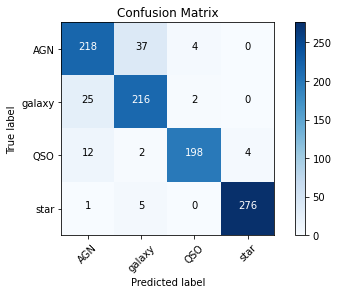

In [32]:
plot_confusion_matrix(cm=cm, classes=class_names, title='Confusion Matrix')

## Treffergenauigkeit der einzelnen Klassen

In [39]:
class_accuaracy = []

for i in range(4):
    total_objects = sum(cm[i])
    correct_guesses = cm[i][i]
    class_accuaracy.append(correct_guesses/total_objects)
    
print("Accuracy for class")
for i in range(4):
    print(class_names[i], "\t:", round(class_accuaracy[i],4)*100, "%")

Accuracy for class
AGN 	: 84.17 %
galaxy 	: 88.89 %
QSO 	: 91.67 %
star 	: 97.87 %


## Confusion matrix mit Prozenten

Confusion matrix, without normalization
[[84.17 14.29  1.54  0.  ]
 [10.29 88.89  0.82  0.  ]
 [ 5.56  0.93 91.67  1.85]
 [ 0.35  1.77  0.   97.87]]


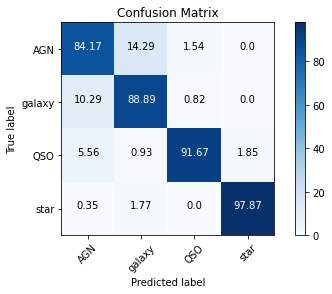

In [42]:
cm = confusion_matrix(y_true=y_test, y_pred=rounded_predictions)

cm_percentages = np.zeros(shape=(4,4))
for i in range(4):
    total_objects = sum(cm[i])
    
    for t in range(4):
        number_guessed = cm[i][t]
        cm_percentages[i][t] = round(number_guessed/total_objects*100,2)

plot_confusion_matrix(cm=cm_percentages, classes=class_names, title='Confusion Matrix')

## Untersuchung der falsch klassifizierten Spektren

**Label 0 = AGN** \
**Label 1 = galaxy** \
**Label 2 = QSO** \
**Label 3 = star**

In [44]:
predictions = model.predict(x=x_test)
rounded_predictions = np.argmax(predictions, axis=-1)

wrong_predictions = []

for i in range(len(rounded_predictions)):
    if rounded_predictions[i] != y_test[i]:
        wrong_predictions.append(numbers_test[i])      

wrong_predictions.sort()
        
print(len(rounded_predictions), "richtig")
print(len(wrong_predictions), "falsch")
print(str(((len(rounded_predictions)-len(wrong_predictions))/len(rounded_predictions))*100) + "% richtig klassifiziert")

1000 richtig
92 falsch
90.8% richtig klassifiziert


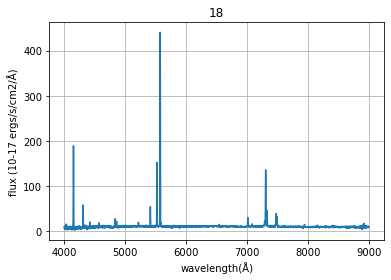

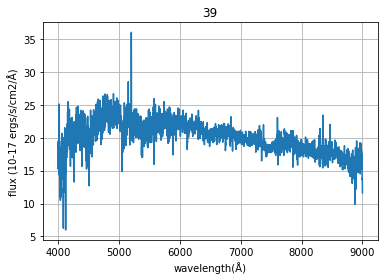

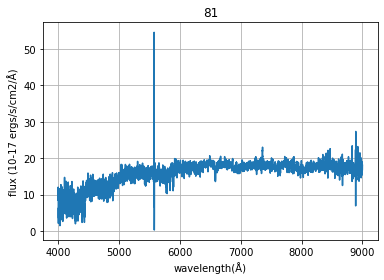

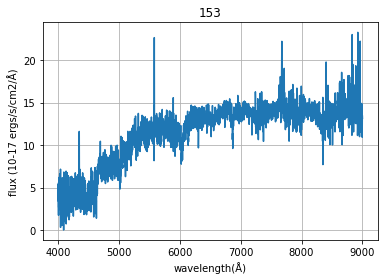

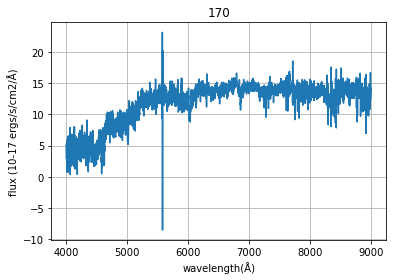

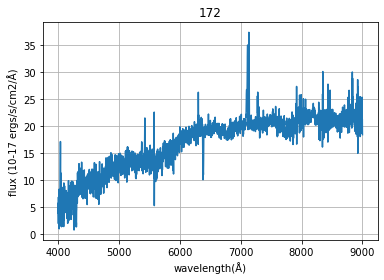

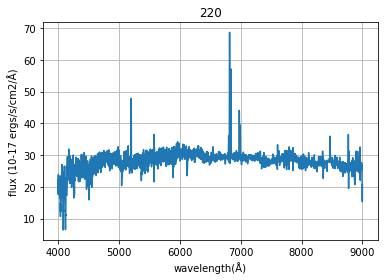

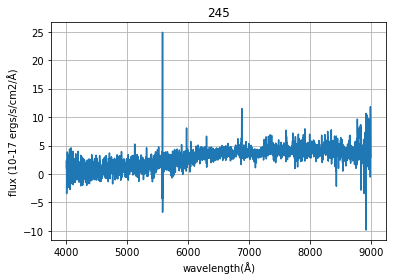

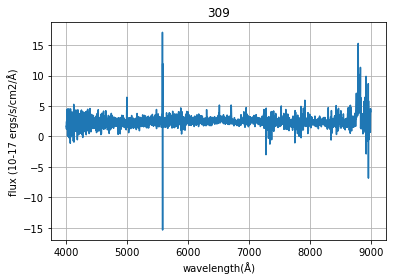

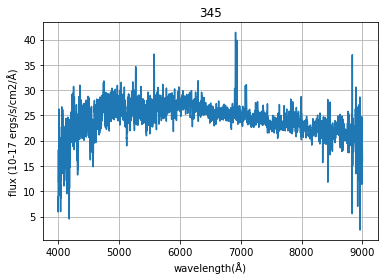

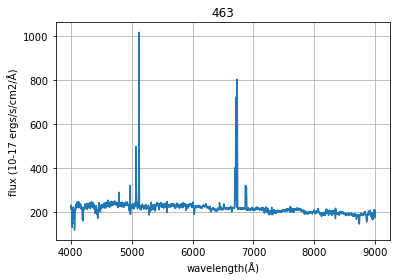

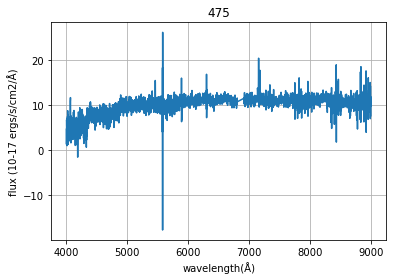

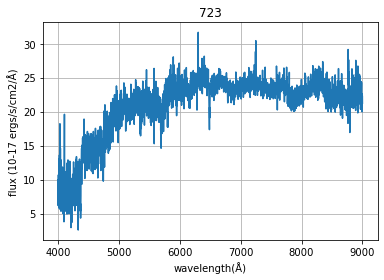

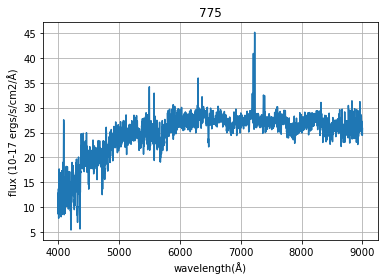

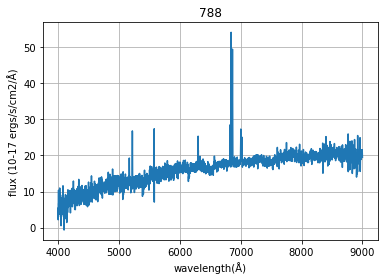

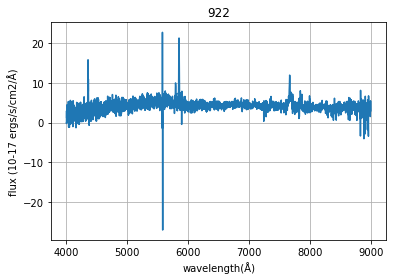

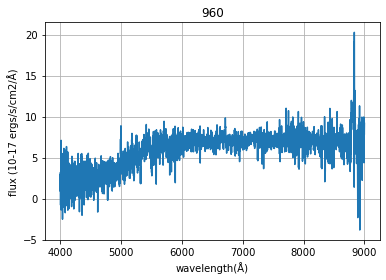

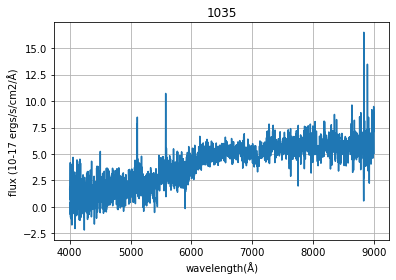

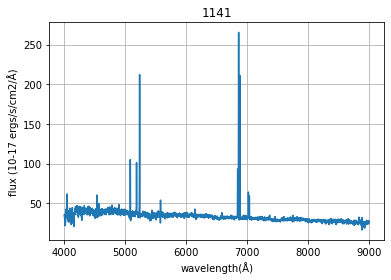

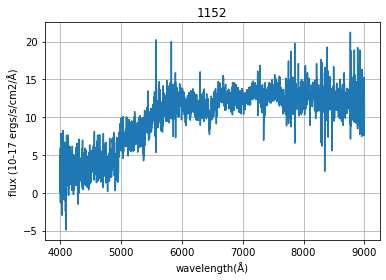

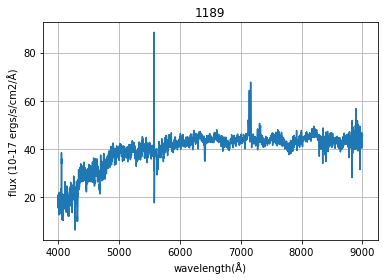

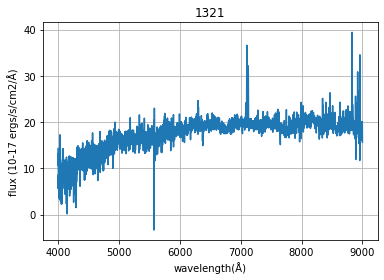

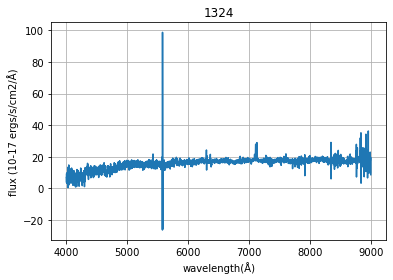

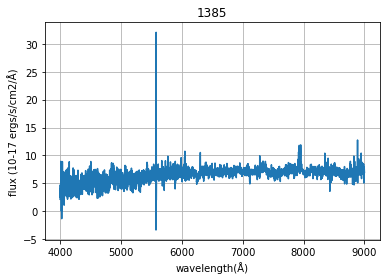

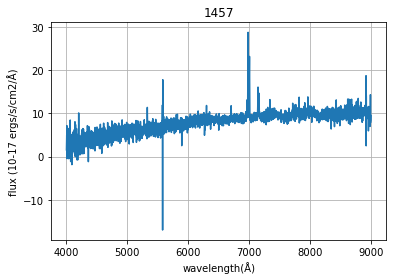

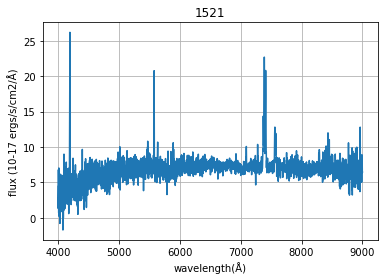

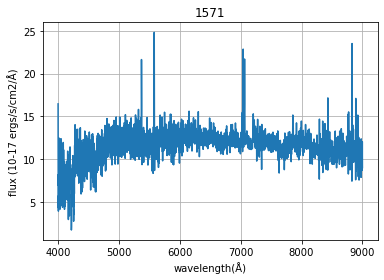

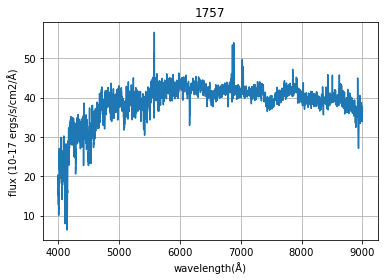

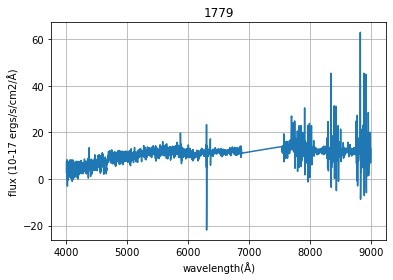

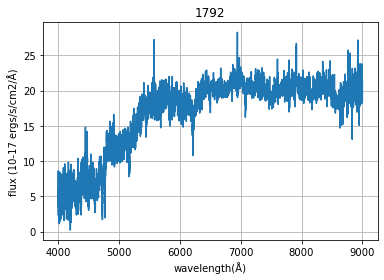

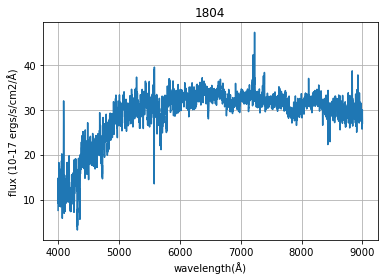

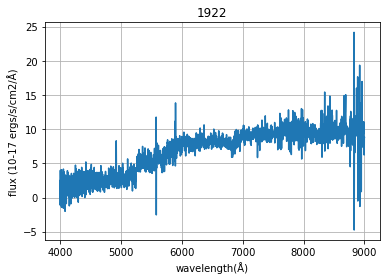

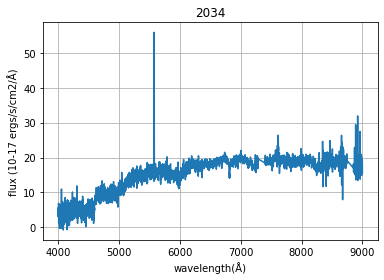

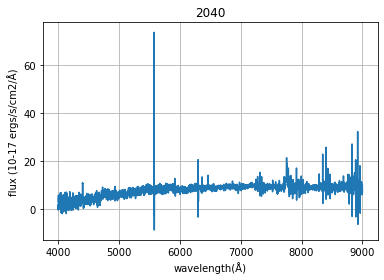

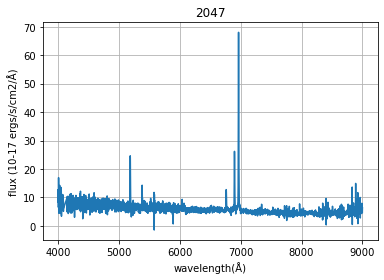

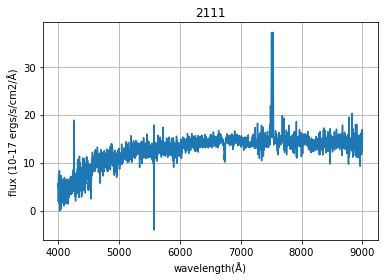

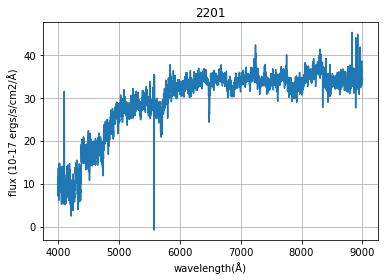

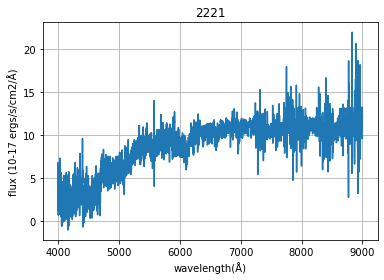

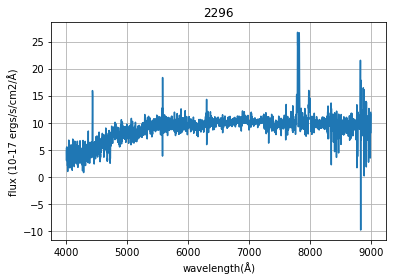

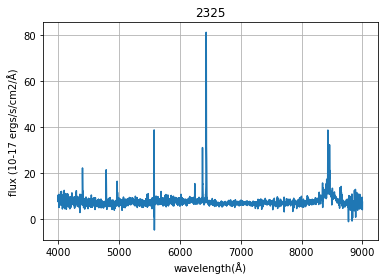

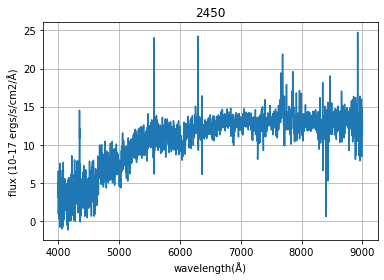

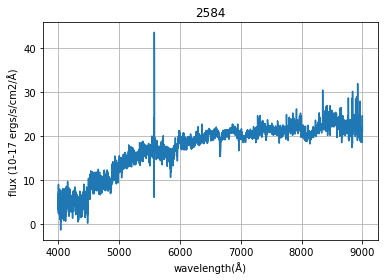

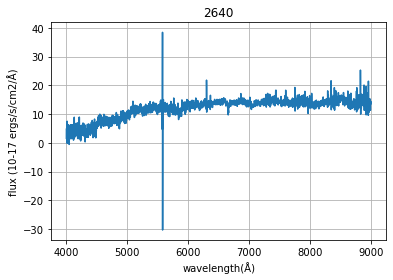

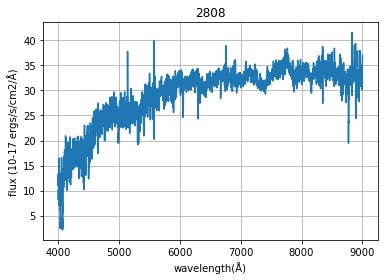

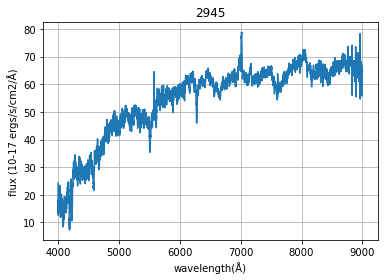

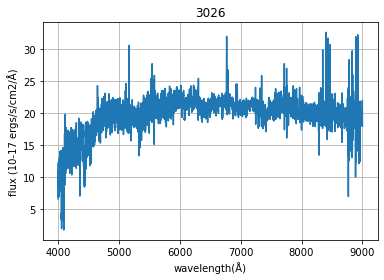

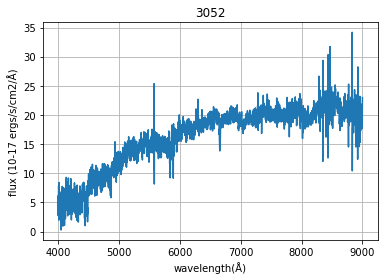

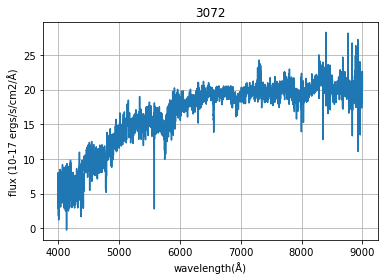

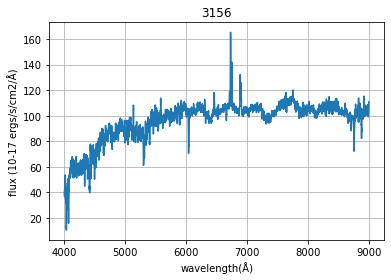

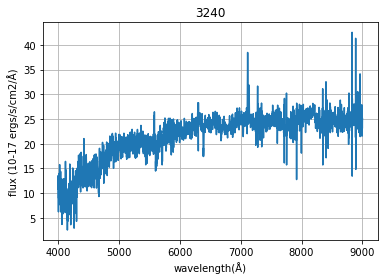

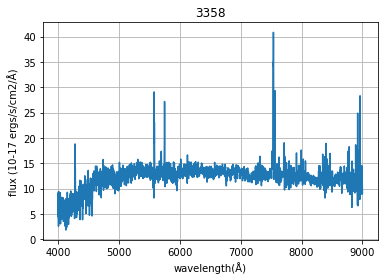

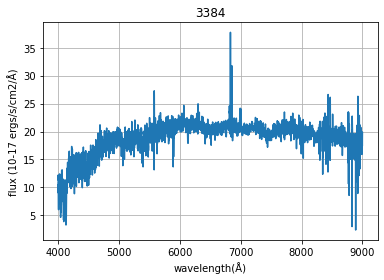

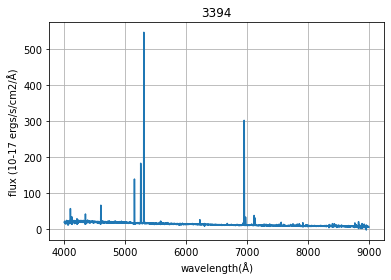

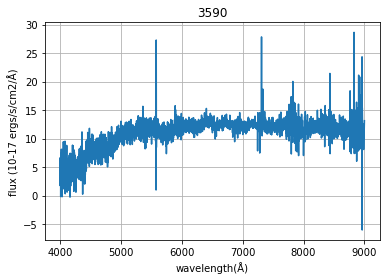

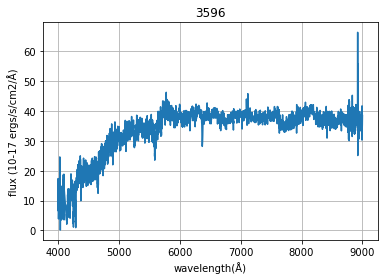

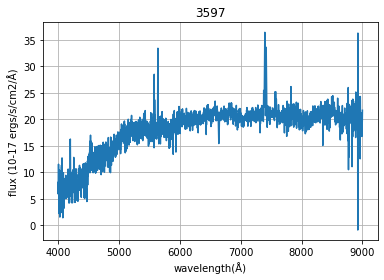

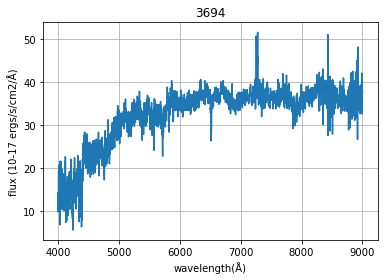

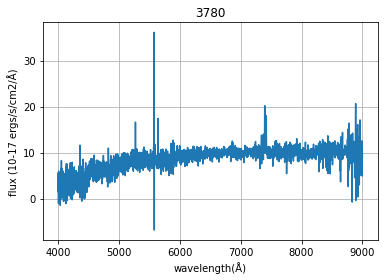

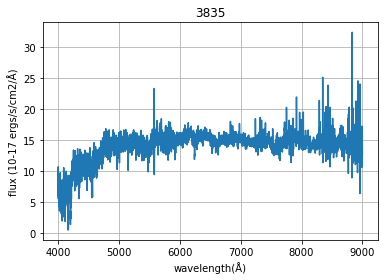

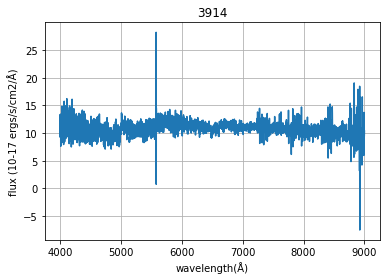

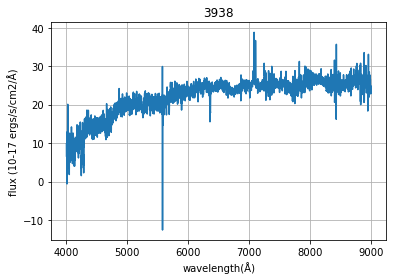

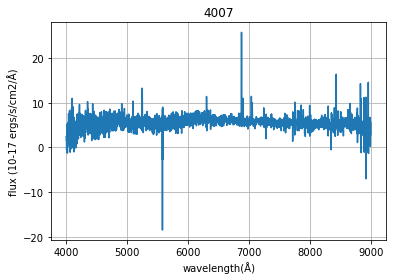

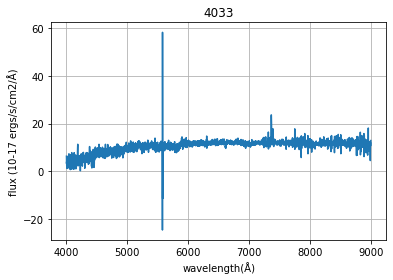

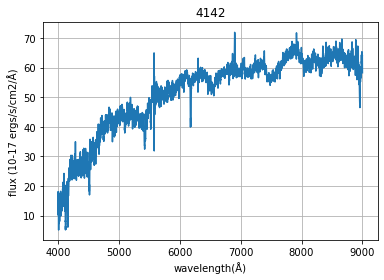

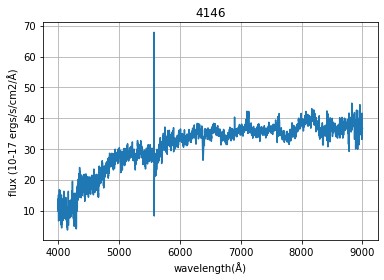

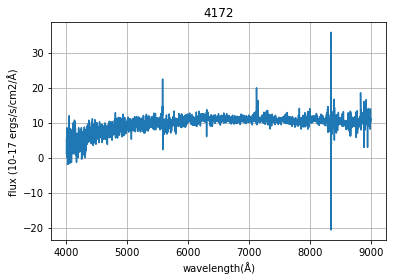

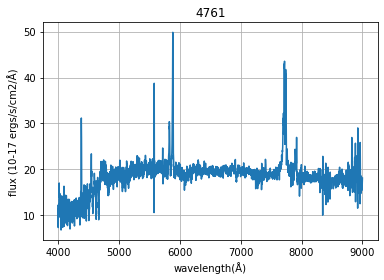

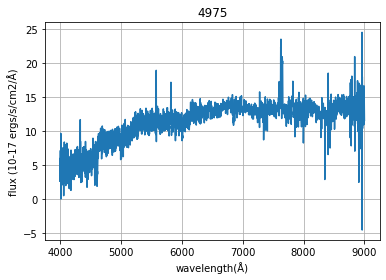

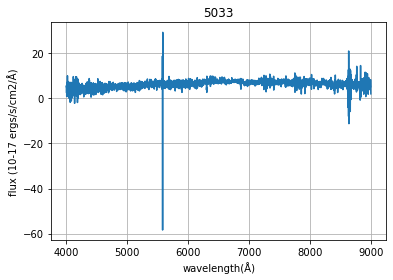

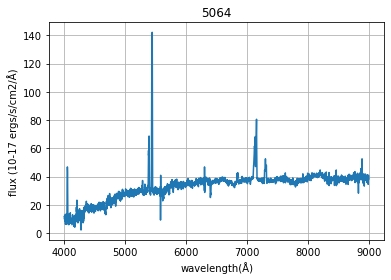

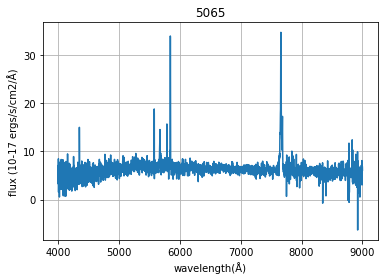

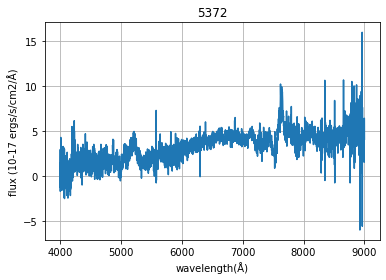

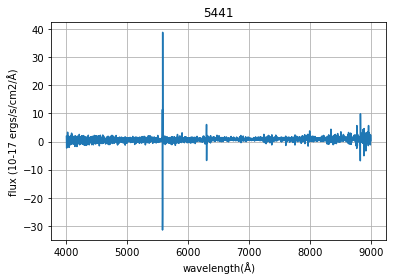

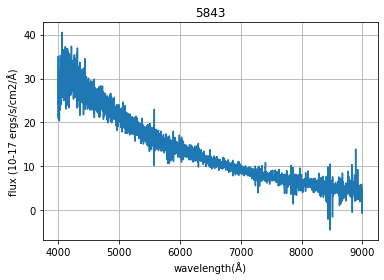

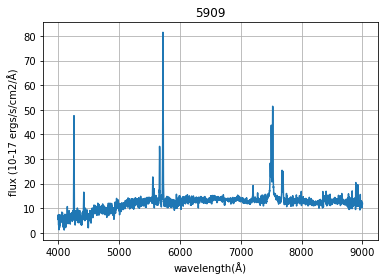

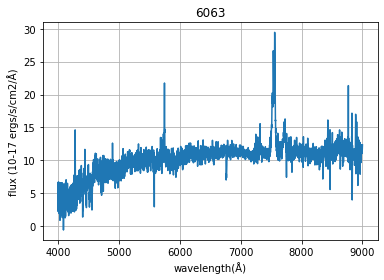

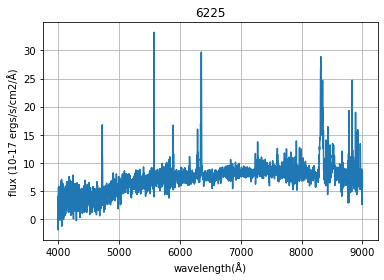

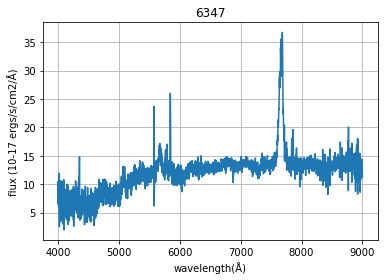

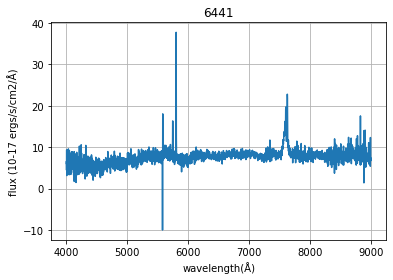

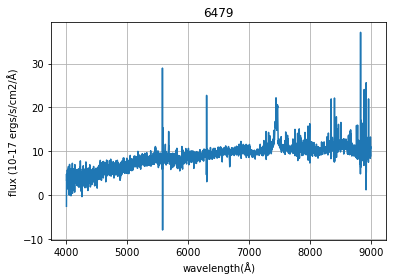

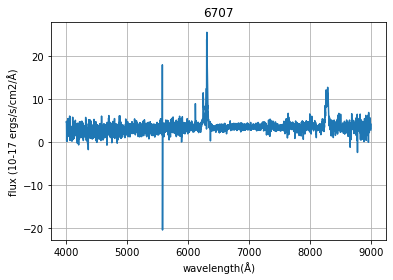

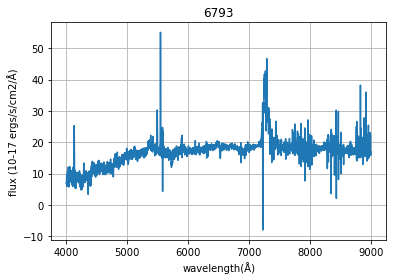

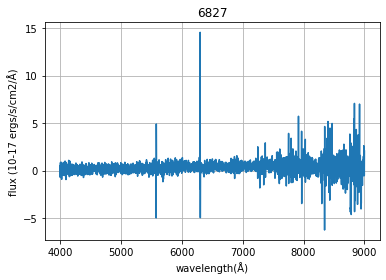

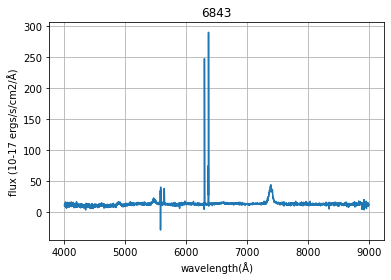

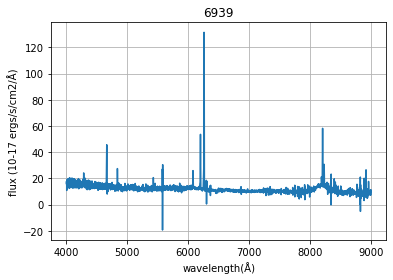

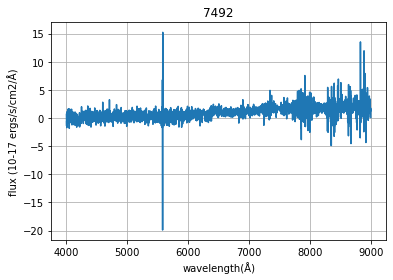

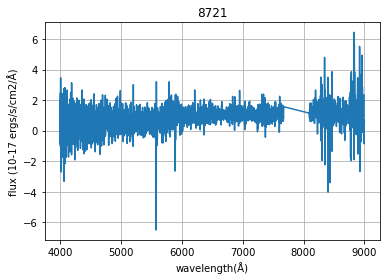

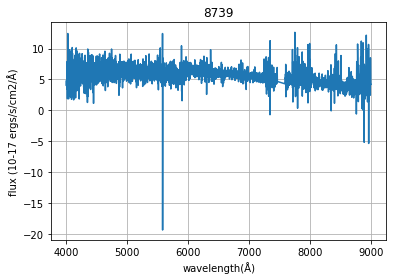

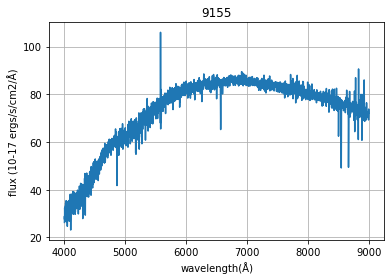

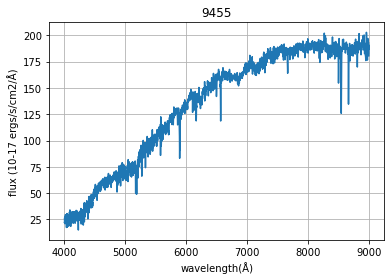

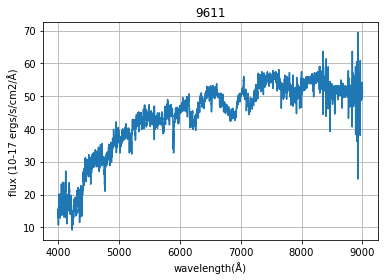

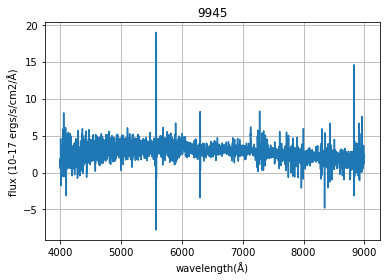

In [45]:
for i in wrong_predictions:  
    plt.plot(wavelengths, data[i]) 
    plt.xlabel('wavelength(Å)') 
    plt.ylabel('flux (10-17 ergs/s/cm2/Å)') 
    plt.grid(True)
    plt.title(str(i))
    plt.show()

## Vergleichs-Benchmark

In [21]:
from sklearn import svm
clf = svm.SVC(gamma=0.001, C=100.)
clf.fit(data_training, labels_training)
clf.score(data_test, labels_test)

0.265

In [22]:
from sklearn.linear_model import LogisticRegression
clf1 = LogisticRegression(max_iter=1000, random_state=123)
clf1.fit(data_training, labels_training)
clf1.score(data_test, labels_test)

C:\Users\Josh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7825

In [23]:
from sklearn.ensemble import RandomForestClassifier
clf2 = RandomForestClassifier(n_estimators=100, random_state=123)
clf2.fit(data_training, labels_training)
clf2.score(data_test, labels_test)

0.7775

In [24]:
from sklearn.naive_bayes import GaussianNB
clf3 = GaussianNB()
clf3.fit(data_training, labels_training)
clf3.score(data_test, labels_test)

0.4425